# Discrepancy Between the Set Tempearature and Estimated Temperature vs Resolution

##### created 2025-05-03, by Kananovich

In [1]:
import numpy as np
import scipy.stats as sts
from scipy import constants as cnst
import pandas as pd
from matplotlib import pyplot as plt

general parameters.

In [31]:
nP = 1000 #number of particles
rho = 1510.0
dust_diam = 7.14E-6
fps = 100 # camera framerate in frames per second
#fps = 295.0 # camera framerate in frames per second
time_step = 1.0 / fps
res_meters_per_px = 1E-6
#res_meters_per_px = 30E-6
resol_SI = 1.0 / res_meters_per_px # camera resolution in px/meters
dust_mass = 4.0 / 3.0 * np.pi * (dust_diam / 2.0)**3 * rho #mass of the dust particles
kin_Tx = 1000.0 #kinetic temperature (in Kelvins) along the x axis
kin_Ty = 1000.0 #kinetic temperature (in Kelvins) along the y axis
drift_x = 0  # asuming the average x-component of the particles is zero (no drift)
drift_y = 0
left_x_bord = 0
right_x_bord = 1751.0 # right border of the field of view in pixels
top_y_bord = 400
bottom_y_bord = 0
left_x_bord_SI = left_x_bord / resol_SI
right_x_bord_SI = right_x_bord / resol_SI #coordinated of the right border
    #of the filed of view in meters


## Function create_art_vels() creates velocities and coords for given parameters

In [3]:
def create_art_vels(tTx, tTy, N_particles, metersPerPx, frps, ro, diam, drift_x, drift_y, left_x, right_x, lefty, right_y):
    import numpy as np
    import scipy.stats as sts
    from scipy import constants as cnst
    resol_SI = 1.0 / metersPerPx # camera resolution in px/meters
   
    dust_mass = 4.0 / 3.0 * np.pi * (diam / 2.0)**3 * ro #mass of the dust particles
    sigma_x = np.sqrt(cnst.k * tTx / dust_mass)
    sigma_y = np.sqrt(cnst.k * tTy / dust_mass)
    left_x_bord_SI = left_x / resol_SI
    right_x_bord_SI = right_x / resol_SI #coordinated of the right border
    time_step = 1.0 / frps


    #Creating the arrays to store data in:
    arr_ind = np.arange(0,N_particles,1,dtype = 'int') # array of particles ID numbers
    arr_first_frame_no = np.zeros(N_particles, dtype = 'int')
    arr_first_frame_no = arr_first_frame_no + int(1)        #array to store the frist frame number
    arr_next_frame_no = np.zeros(N_particles, dtype = 'int')
    arr_next_frame_no = arr_next_frame_no + int(2)        #array to store the frist frame number

    #array to store the "nonexistent" data:

    arr_nan = np.empty(N_particles)
    arr_nan.fill(np.nan)
    
    

    artif_vx_rv = sts.norm(drift_x,sigma_x)
    arr_sample_vx = artif_vx_rv.rvs(N_particles)

    #Array of artificial coordinates for the "previous" frame:
    art_x_prev_rv = sts.uniform(left_x_bord_SI, right_x_bord_SI - left_x_bord_SI)
    arr_sample_prev_x = art_x_prev_rv.rvs(N_particles)

    arr_prev_x_inResolChunks = arr_sample_prev_x * resol_SI
    arr_prev_x_inResolChunks_int = arr_prev_x_inResolChunks.astype(int)
    arr_rough_prev_x = arr_prev_x_inResolChunks_int.astype('float64') / resol_SI
    
    ## Step 3. Creating an array of artificial coordinates for the "next frame"
    arr_next_x = arr_rough_prev_x + arr_sample_vx * time_step
    arr_next_x_inResolChunks = arr_next_x * resol_SI
    arr_next_x_inResolChunks_int = arr_next_x_inResolChunks.astype('int64')
    arr_rough_next_x = arr_next_x_inResolChunks_int.astype('float64') / resol_SI

## Step 4: Calculating the "restored" velocities:
    arr_vx_restored = (arr_rough_next_x - arr_rough_prev_x) / time_step

    #saving all the data in the output dataframe:
    
    #first, create a dataframe storing the data of the first 'video frame':
    
    dataFirstFrame = {'particle':arr_ind, 'frame':arr_first_frame_no, 'x': arr_rough_prev_x, 'vx':arr_vx_restored, 'real_vx': arr_sample_vx}
    first_df = pd.DataFrame(dataFirstFrame)
    
    #the same for the next video frame:

    dataNextFrame = {'particle':arr_ind, 'frame':arr_next_frame_no, 'x': arr_rough_next_x, 'vx':arr_nan, 'real_vx': arr_nan}
    next_df = pd.DataFrame(dataNextFrame)
    
    ret_df = pd.concat([first_df,next_df], ignore_index = True)
    return ret_df


## Check if the Function works:

In [32]:
df = create_art_vels(kin_Tx, kin_Ty, nP, res_meters_per_px, fps, rho, dust_diam, drift_x, drift_y, left_x_bord, right_x_bord, bottom_y_bord, top_y_bord)
df_first = df[df['frame'] == 1]
arr_vxTheor = np.array(df_first['real_vx'])

### Histogram with the real velocities:

<BarContainer object of 19 artists>

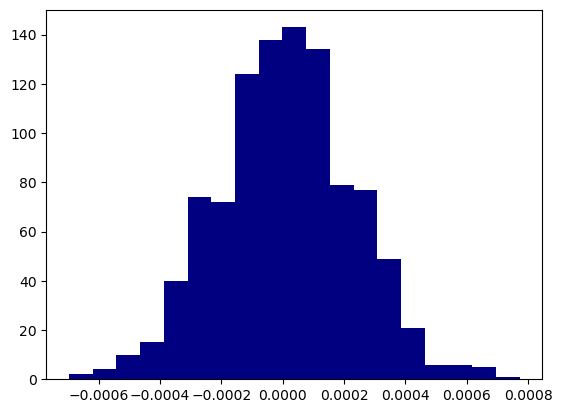

In [33]:
counts_xt, bins_xt = np.histogram(arr_vxTheor, bins = 19)
fig_x, ax_x = plt.subplots()
arr_bins_centers = 0.5 * (bins_xt[1:] + bins_xt[:-1])
ax_x.bar(arr_bins_centers, counts_xt, width = (arr_bins_centers[1] - arr_bins_centers[0]), color = 'navy')

## Overplot the histogram with the "Restored" velocities

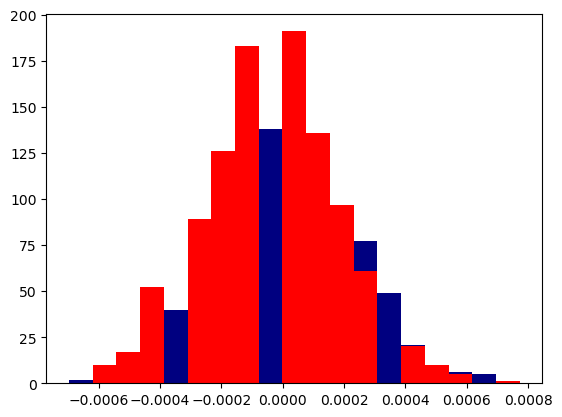

In [34]:
bins_x = arr_bins_centers - 0.5 * (arr_bins_centers[1] - arr_bins_centers[0])
bins_x = np.append(bins_x, bins_x[-1] + (bins_x[1] - bins_x[0]))
arr_vx = np.array(df_first['vx'])
counts_xe, bins_xe = np.histogram(arr_vx, bins = bins_x)
arr_bins_e_centers = 0.5 * (bins_xe[1:] + bins_xe[:-1])
ax_x.bar(arr_bins_e_centers, counts_xe, width = (arr_bins_centers[1] - arr_bins_centers[0]), color = 'red')
fig_x

## Restored velocities histogram, separately:

<BarContainer object of 19 artists>

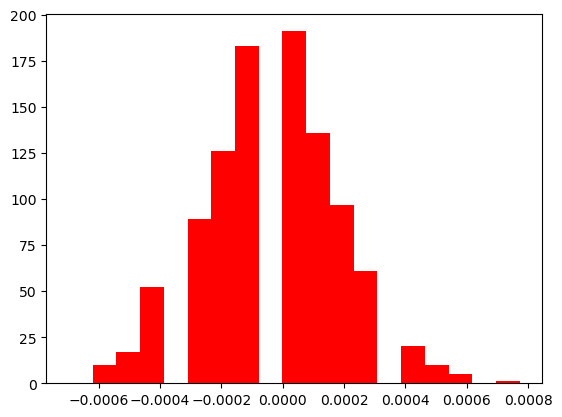

In [35]:
fig_x_e, ax_x_e = plt.subplots()
ax_x_e.bar(arr_bins_e_centers, counts_xe, width = (arr_bins_centers[1] - arr_bins_centers[0]), color = 'red')

## Use the Function in Cycle and Calculate Temperature Discrepancy for Every Resolution:

In [18]:
arr_resol = np.arange(1E-9,1E-6,1E-8)
arr_discrep = np.zeros(len(arr_resol))

In [29]:
for i in range(0, len(arr_resol)):
    res_i = arr_resol[i]
    df_i = create_art_vels(kin_Tx, kin_Ty, nP, res_i, fps, rho, dust_diam, drift_x, drift_y, left_x_bord, right_x_bord, bottom_y_bord, top_y_bord)
    df_i_ff = df_i[df_i['frame'] == 1]
    std_i = np.std(df_i['vx'])
    tT = std_i**2 * dust_mass / cnst.k
    arr_discrep[i] = np.abs((kin_Tx - std_i**2 * dust_mass / cnst.k)) / kin_Tx
    

Text(0, 0.5, 'discrepancy (%)')

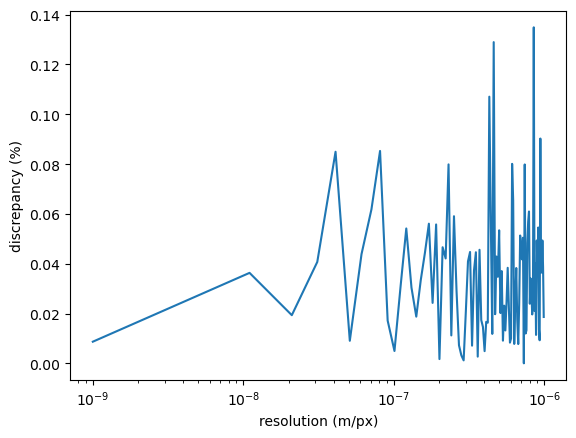

In [30]:
fig, ax = plt.subplots()
ax.plot(arr_resol, arr_discrep)
ax.set_xscale('log')
ax.set_xlabel('resolution (m/px)')
ax.set_ylabel("discrepancy (%)")